# Step 1: Noise Generation
1.**Gaussian Noise:** 
Add Gaussian noise to images using a function that generates random numbers following a Gaussian distribution. You can control the amount of noise by adjusting the standard deviation.

2.**Salt and Pepper Noise:**
Introduce random white and black pixels (salt and pepper noise) to the images. You can control the density of these pixels to adjust the severity of the noise.

3.**Speckle Noise:**
Apply speckle noise by multiplying the image by a random matrix with values following a uniform distribution centered around 1. Again, control the intensity of noise.

4.**Poisson Noise:**
Simulate Poisson noise by adding random values sampled from a Poisson distribution to the pixel values in the images.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [33]:
# Load the Lena image
lena_image = cv2.imread('../lena.jpg', cv2.IMREAD_GRAYSCALE)

# Noise Functions

In [41]:
def add_salt_and_pepper_noise(image, density):
    noisy_image = np.copy(image)
    num_pixels = int(density * image.size)

    # Salt noise
    salt_coords = [np.random.randint(0, i - 1, int(num_pixels / 2)) for i in image.shape]
    noisy_image[salt_coords] = 255

    # Pepper noise
    pepper_coords = [np.random.randint(0, i - 1, int(num_pixels / 2)) for i in image.shape]
    noisy_image[pepper_coords] = 0

    return noisy_image

def add_speckle_noise(image, variance):
    noise = np.random.normal(0, variance, image.shape)
    noisy_image = image + image * noise
    noisy_image = np.clip(noisy_image, 0, 255)  # Clip values to valid intensity range
    return noisy_image.astype(np.uint8)

def add_noise(noise, image, variance):
    if noise == 'salt_and_pepper':
        noisy_image = add_salt_and_pepper_noise(image, variance)
    elif noise == 'speckle':
        noisy_image = add_speckle_noise(image, variance)
    else:
        noisy_image = image
    return noisy_image

# Filter Functions & General Functions

In [39]:
# Function to apply denoising filters
def apply_filters(image, filter_type, filter_size, wavelet_type='haar'):
    if filter_type == 'median':
        return cv2.medianBlur(image, filter_size)
    elif filter_type == 'gaussian':
        return cv2.GaussianBlur(image, (filter_size, filter_size), 0)
    elif filter_type == 'bilateral':
        return cv2.bilateralFilter(image, filter_size, 75, 75)
    elif filter_type == 'blur':
        return cv2.blur(image, (filter_size, filter_size))
    elif filter_type == 'laplacian':
        return cv2.Laplacian(image, cv2.CV_64F, ksize=filter_size)
    elif filter_type == 'sobel':
        return cv2.Sobel(image, cv2.CV_64F, 1, 1, ksize=filter_size)
    elif filter_type == 'roberts':
        kernel = np.array([[1, 0], [0, -1]])
        return cv2.filter2D(image, -1, kernel)
    elif filter_type == 'high_pass':
        kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
        return cv2.filter2D(image, -1, kernel)
    elif filter_type == 'unsharp_masking':
        kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        return cv2.filter2D(image, -1, kernel)
    elif filter_type == 'wavelet':
        return cv2.dwt(image, wavelet_type)
    elif filter_type == 'shearlet':
        return cv2.dct(image)


def plot_results(image ,noise_type, noise_variances, filter_types, filter_sizes):
    fig, axes = plt.subplots(len(noise_variances), len(filter_sizes) * len(filter_types) + 1, figsize=(15, 10))
    
    # Plot original image
    axes[0, 0].imshow(lena_image, cmap='gray')
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')


    for i, density in enumerate(noise_variances):
        noisy_image = add_noise(noise_type, lena_image, density)
        axes[i, 0].imshow(noisy_image, cmap='gray')
        axes[i, 0].set_title(f'Noisy (Density {density})')
        axes[i, 0].axis('off')

        for j, filter_type in enumerate(filter_types):
            for k, filter_size in enumerate(filter_sizes):
                denoised_image = apply_filters(noisy_image, filter_type, filter_size)
                axes[i, j * len(filter_sizes) + k + 1].imshow(denoised_image, cmap='gray')
                axes[i, j * len(filter_sizes) + k + 1].set_title(f'{filter_type.capitalize()} Filter (Size {filter_size})')
                axes[i, j * len(filter_sizes) + k + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

def add_noise_to_dataset(noise_type, noise_variances, input_folder, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through image categories
    categories = ['Med', 'Normal', 'RS']
    for category in categories:
        input_category_folder = os.path.join(input_folder, category)
        output_category_folder = os.path.join(output_folder, category)

        # Create output category folder if it doesn't exist
        if not os.path.exists(output_category_folder):
            os.makedirs(output_category_folder)

        # Iterate through images in the category folder
        for filename in os.listdir(input_category_folder):
            if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                input_image_path = os.path.join(input_category_folder, filename)
                output_image_path = os.path.join(output_category_folder, filename)

                # Read the original image
                original_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)

                # Get the corresponding noise variance for the current image
                # Cycle through noise_variances in a circular manner
                noise_variance = noise_variances.pop(0)
                noise_variances.append(noise_variance)

                # Add speckle noise
                noisy_image = add_noise(noise_type, original_image, noise_variance)

                # Save the noisy image
                cv2.imwrite(output_image_path, noisy_image)

    print("Noise added to images with varying variances and saved in 'dataset-noise' folder.")

def apply_filter_on_file_samples_and_plot_them(images, filter_type, filter_size):
    fig, axes = plt.subplots(len(images), len(filter_sizes) * len(filter_types) + 1, figsize=(15, 10))
    for i, image in enumerate(images):
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title('Noisy')
        axes[i, 0].axis('off')

        for j, filter_type in enumerate(filter_types):
            for k, filter_size in enumerate(filter_sizes):
                denoised_image = apply_filters(image, filter_type, filter_size)
                axes[i, j * len(filter_sizes) + k + 1].imshow(denoised_image, cmap='gray')
                axes[i, j * len(filter_sizes) + k + 1].set_title(f'{filter_type.capitalize()} Filter (Size {filter_size})')
                axes[i, j * len(filter_sizes) + k + 1].axis('off')

def read_random_samples_from_dataset(input_folder, num_samples):
    # Iterate through image categories
    categories = ['Med', 'Normal', 'RS']
    images = []
    for category in categories:
        input_category_folder = os.path.join(input_folder, category)

        # Iterate through images in the category folder
        for filename in os.listdir(input_category_folder):
            if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                input_image_path = os.path.join(input_category_folder, filename)

                # Read the original image
                original_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
                images.append(original_image)
    
    # Choose random samples from the dataset
    random_samples = np.random.choice(images, num_samples, replace=False)
    return random_samples

# Salt and Pepper noise

### different noise densities : 0.05, 0.1, 0.2, 0.4

### Density 0.05:

- **Noisy Image:** 
  - At this low density, the original image is mostly preserved with a few randomly scattered salt and pepper pixels.

- **Filter Effects:(MEDIAN FILTER)**
  - Small filters (e.g., size 3x3):
    - Will effectively remove some of the isolated salt and pepper pixels.

  - Medium filters (e.g., size 5x5):
    - Can further reduce the impact of salt and pepper noise.
    - Balances noise reduction and some loss of details.

  - Large filters (e.g., size 7x7):
    - Will have a stronger smoothing effect.
    - Lead to a large loss of some fine details (blurred image).

### Density 0.1:

- **Noisy Image:** 
  - More noticeable salt and pepper noise compared to the lower density.

- **Filter Effects(MEDIAN FILTER):**
  - Small filters:
    - Will remove noise.

  - Medium filters:
    - more effective in reducing noise.
    - Some loss of finer details, but overall noise reduction is significant.

  - Large filters:
    - a stronger impact on noise reduction.
    - further loss of details, especially in textured regions.

### Density 0.2:

- **Noisy Image:** 
  - Substantial salt and pepper noise, impacting the overall quality of the image.

- **Filter Effects(MEDIAN FILTER):**
  - Small filters:
    - Limited effectiveness in handling the high density of noise.

  - Medium filters:
    - Better noise reduction compared to small filters.
    - Potential blurring of edges and details.

  - Large filters:
    - Strong noise reduction but at the cost of significant blurring.
    - Details and textures might be heavily smoothed.

### Density 0.4:

- **Noisy Image:** 
  - High density of salt and pepper noise, severely affecting the image clarity.

- **Filter Effects(MEDIAN FILTER):**
  - Small filters:
    - Limited effectiveness; noise still dominate the image.

  - Medium filters:
    - Some reduction in noise, but the image appear overly smoothed.
    - Substantial loss of finer details.

  - Large filters:
    - Strong noise reduction, but at the expense of image details.
    - Image become overly smooth, and fine textures are lost.

### General Considerations:

- **Trade-off:**
  - There's always a trade-off between noise reduction and preserving image details. Smaller filters preserve details but may not handle intense noise, while larger filters are better at noise reduction but may overly smooth the image.

- **Optimal Filter Size:**
  - The optimal filter size may vary based on the specific characteristics of the image and the desired trade-off between noise reduction and detail preservation. Experimentation is crucial to find the right balance for a given scenario.

- **Algorithm Choice:**
  - Different denoising algorithms may perform differently on various noise densities. It's worth exploring different algorithms and their parameter settings to achieve the best results for a particular application.


### Median Filter and Gaussian Filter Comparison:
  - The median filter is more effective in removing salt and pepper noise compared to Gaussian noise. 
  - The median filter is better at preserving edges and fine details compared to the Gaussian filter.


C:\Users\alast\AppData\Local\Temp\ipykernel_13036\2631455274.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  noisy_image[salt_coords] = 255
C:\Users\alast\AppData\Local\Temp\ipykernel_13036\2631455274.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  noisy_image[pepper_coords] = 0


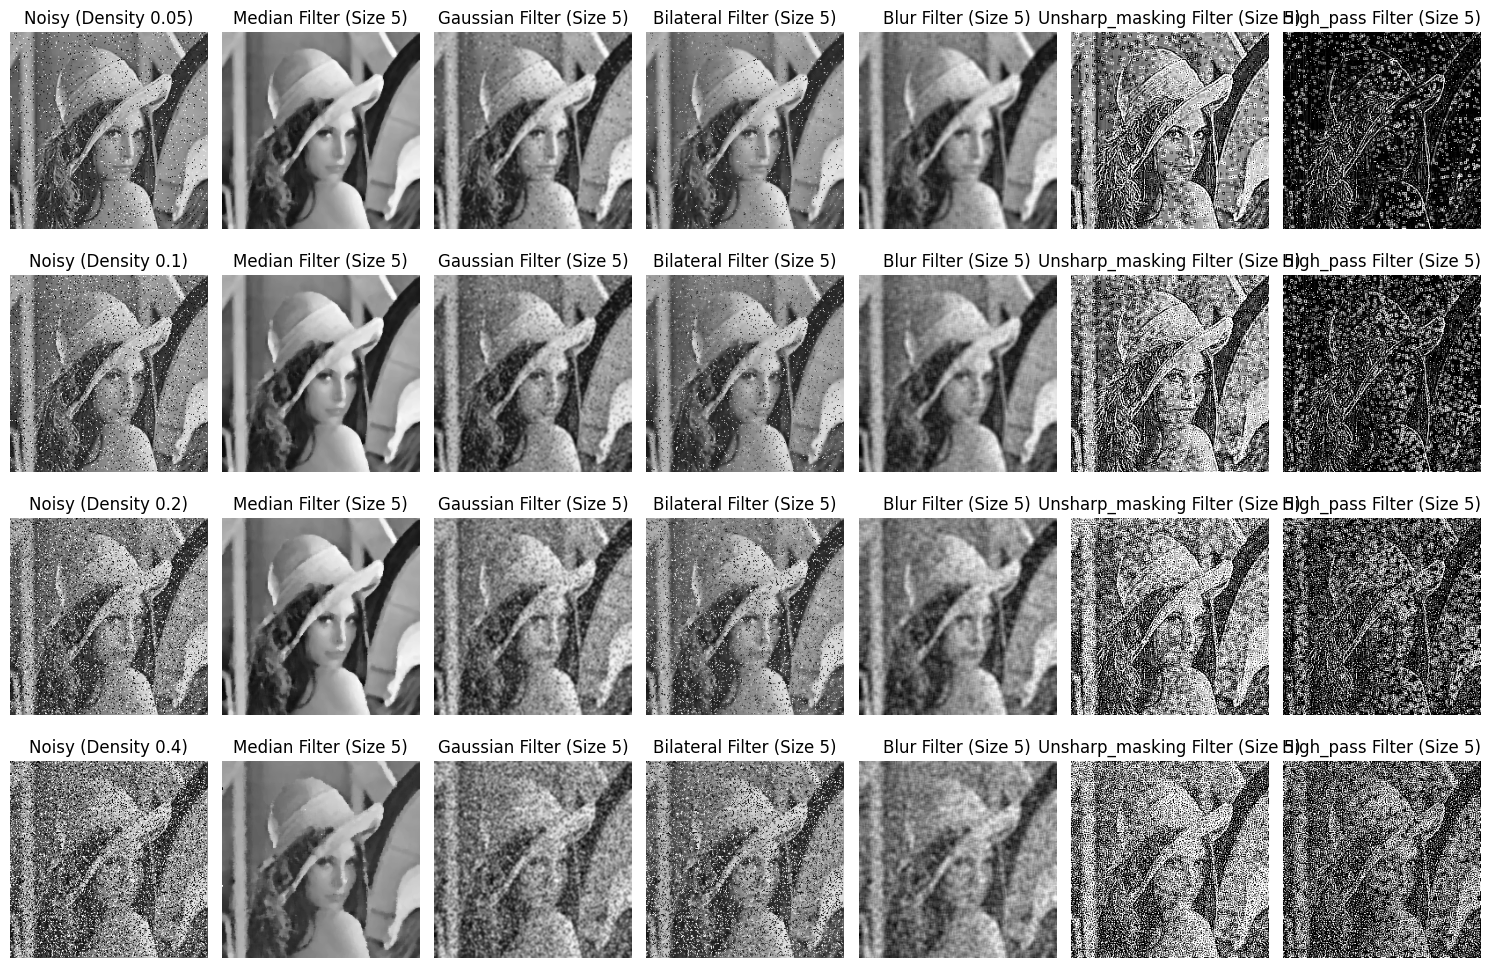

In [51]:
# Noise densities to try
noise_densities = [0.05, 0.1, 0.2, 0.4]

# Filter types to try
filter_types = ['median', 'gaussian', 'bilateral', 'blur', 'unsharp_masking', 'high_pass']

# Filter sizes to try
filter_sizes = [5]


# Apply Salt and Pepper noise, then denoising filters
plot_results(lena_image, 'salt_and_pepper', noise_densities, filter_types, filter_sizes)

# Salt and Pepper noise on different images

## Conclusion:
- The median filter is more effective in removing salt and pepper noise compared to Gaussian noise just like the previous case.
- The median filter is better at preserving edges and fine details compared to the Gaussian filter just like the previous case.

therefore, the median filter is better than the gaussian filter in removing salt and pepper noise.

C:\Users\alast\AppData\Local\Temp\ipykernel_13036\1186168982.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_samples = np.random.choice(images, num_samples, replace=False)


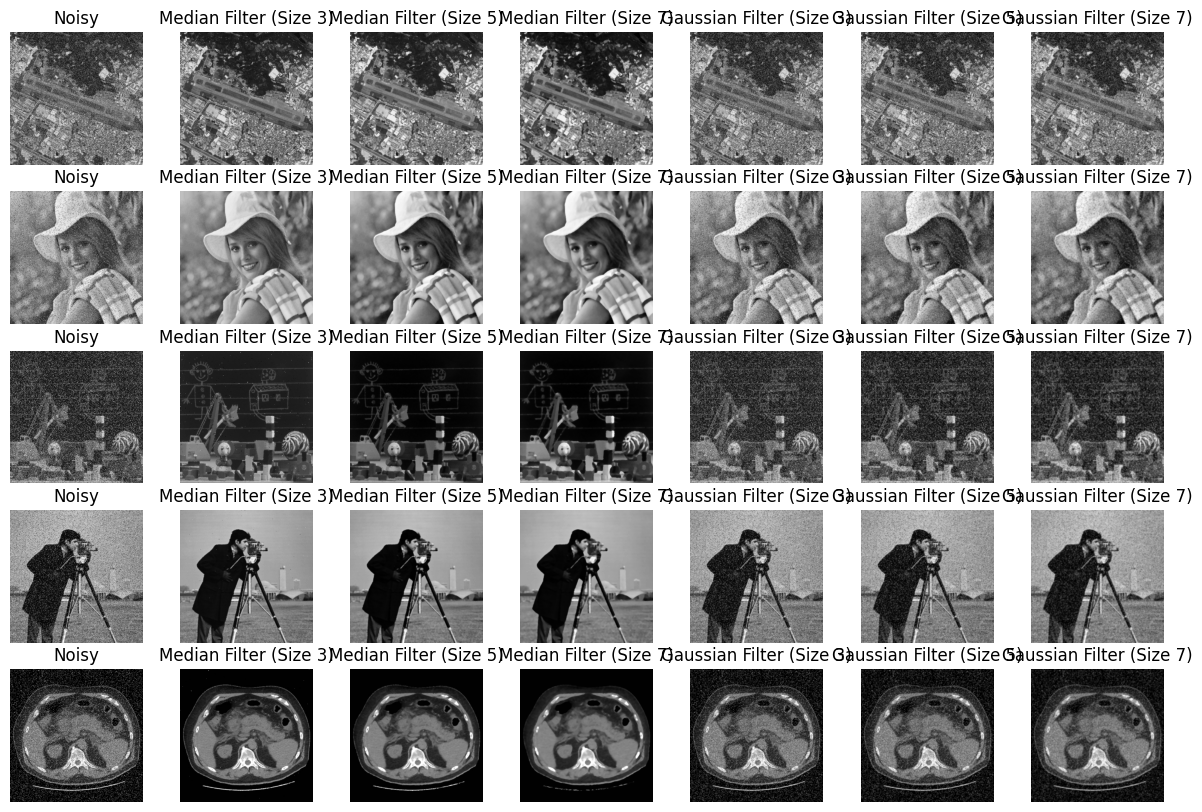

In [43]:
images = read_random_samples_from_dataset('dataset-noise-salt-and-pepper', 5)
apply_filter_on_file_samples_and_plot_them(images, filter_types, filter_sizes)

# imply  speckle  noise.

### different  noise  variance: 0.005, 0.05, 0.5, 1

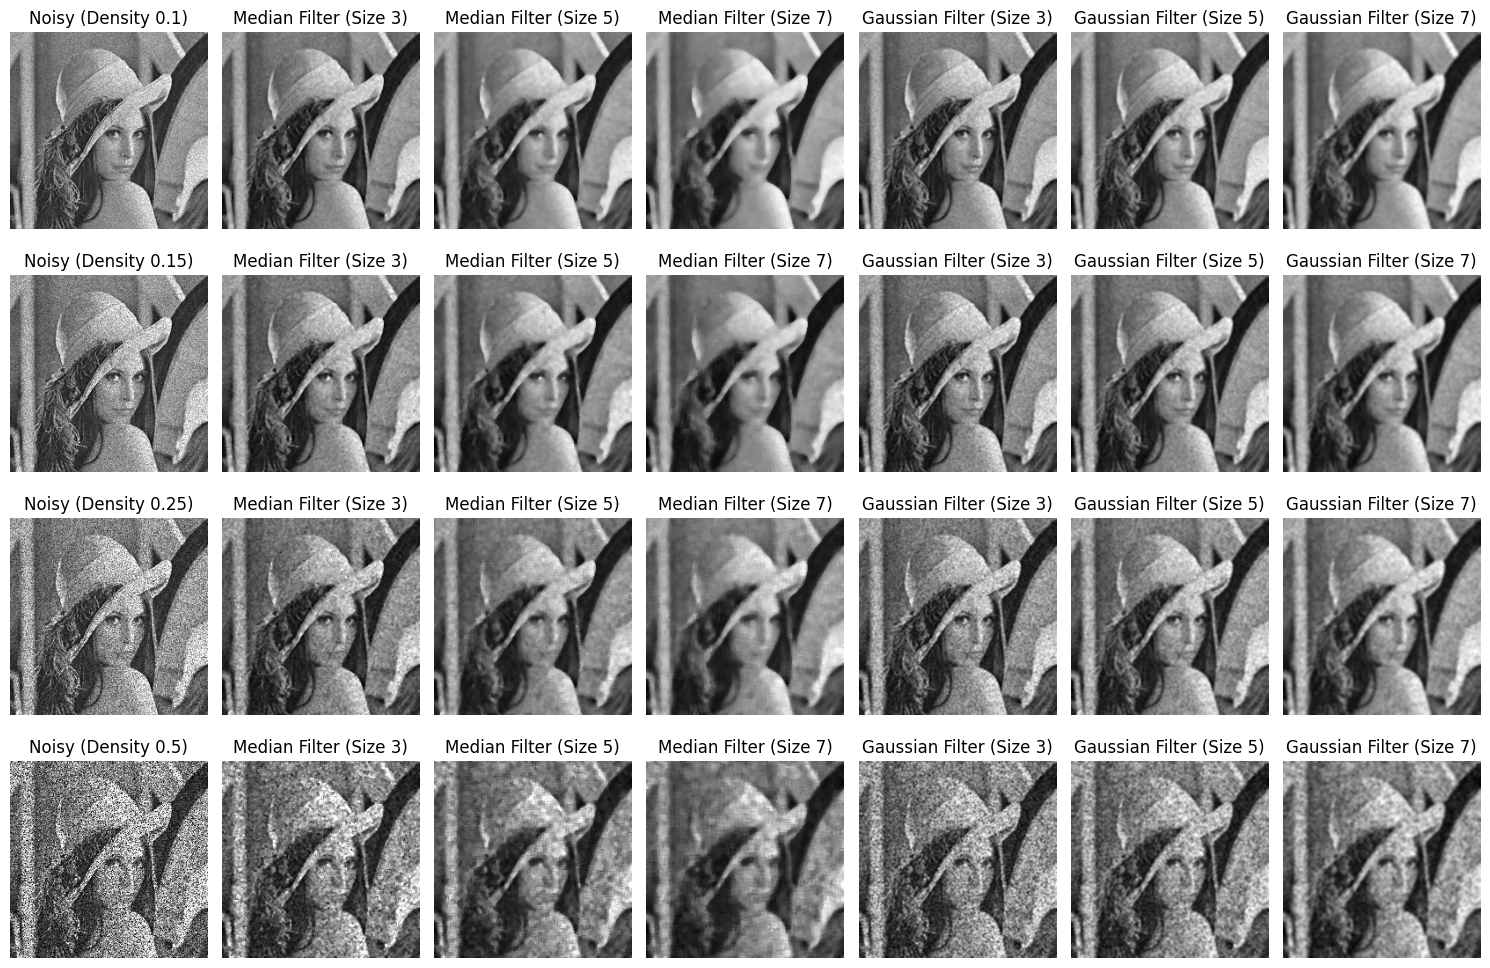

In [44]:
noise_variances = [0.1, 0.15, 0.25, 0.5]



# Apply Speckle noise, then denoising filters
plot_results(lena_image, 'speckle', noise_variances, filter_types, filter_sizes)